In [1]:
import os, multiprocessing, cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from libvisu import *
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set a wide width for display
pd.set_option('display.colheader_justify', 'center')  # Align column headers

All images have been preloaded locally!


## Configuration

In [2]:
# Path to the folder containing the pictures
rootpath_imgs = '/Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/24.11-25.01_metabolism_OH/Images/'                        # For images
rootpath_data = '/Users/cyrilmonette/Desktop/EPFL 2018-2026/PhD - Mobots/ABC/ABCVisualisation/data/2025-01-03_13-06_influxdb_data.csv'  # For CO2, htr and tmp data
hive = "1"
t_res = "1min" # Image time resolution. Change only if images are not taken every minute. Use frame_drop to keep only some frames, not this.

first_dt = "241215-120000Z"
last_dt = "241218-040000Z"
frame_drop = 10 # We keep 1 frame every frame_drop frames. Put one to keep all frames.

Hive.resize_factor = 10.1 # Resize factor for the thermal images relative to the IR images
Hive.inter_htr_dist = 25 # Distance between heaters in pixels
Hive.htr_shift_x = 260 # Shift in x direction of the heaters in pixels
Hive.htr_shift_y = 570 # Shift in y direction of the heaters in pixels
Hive.htr_size=(800,800) # Size of the heaters in pixels (width, height)

## Running

#### Image fetching

In [ ]:
# Get the target dt (for which we need an image, data, etc.)
datetimes = pd.date_range(start=pd.to_datetime(first_dt, format='%y%m%d-%H%M%S%z'), end=pd.to_datetime(last_dt, format='%y%m%d-%H%M%S%z'), freq=t_res)
datetimes = datetimes[::frame_drop]

# Get the list of folders in the rootpath
paths = [os.path.join(rootpath_imgs, f) for f in os.listdir(rootpath_imgs) if os.path.isdir(os.path.join(rootpath_imgs, f))]
paths = [path for path in paths if "h"+hive in path]
rpis = [path.split("/")[-1][3] for path in paths]

# Order the paths alphabetically
paths.sort() # Now this contains the path to all RPis images

# For each dt in datetimes, find the image path that == dt for each RPi. Put the paths in a df where each row is a dt and each column is a RPi
imgs_paths = pd.DataFrame(index=datetimes, columns=[os.path.basename(path)[:4] for path in paths])
for dt in datetimes:
    for path in paths:
        filename = "hive"+hive+"_rpi"+path.split("/")[-1][3]+"_"+dt.strftime('%y%m%d-%H%M')
        # Find the file in os.listdir(path) that contains the dt (or startswith(dt))
        img_path = [os.path.join(path, f) for f in os.listdir(path) if filename in f]
        if len(img_path) == 1:
            imgs_paths.loc[dt, os.path.basename(path)[:4]] = img_path[0]
        else:
            imgs_paths.loc[dt, os.path.basename(path)[:4]] = None

# Check how many images are missing
print("Missing images: ", imgs_paths.isnull().sum().sum())

In [ ]:
images_fill_limit = 30 # 30 * 10 = 300 minutes = 5 hours
# Print the index and columns of all missing values
print(imgs_paths[imgs_paths.isnull().any(axis=1)])

# Fill the gaps with the images from the previous dt
imgs_paths_filtered = imgs_paths.ffill(limit=images_fill_limit,axis=0)
# Check if there are still missing images, if so, raise an error
if imgs_paths_filtered.isnull().sum().sum() > 0:
    raise ValueError(f"Still missing images, desipite filling the gaps with the previous images up to {images_fill_limit} images.")   
print("Missing images after filling: ", imgs_paths_filtered.isnull().sum().sum())


                           h1r1                        h1r2                                               h1r3                                               h1r4                       
2024-12-17 09:30:00+00:00  None  /Users/cyrilmonette/Library/CloudStorage/Synol...  /Users/cyrilmonette/Library/CloudStorage/Synol...  /Users/cyrilmonette/Library/CloudStorage/Synol...
2024-12-17 09:40:00+00:00  None  /Users/cyrilmonette/Library/CloudStorage/Synol...  /Users/cyrilmonette/Library/CloudStorage/Synol...  /Users/cyrilmonette/Library/CloudStorage/Synol...
2024-12-17 09:50:00+00:00  None  /Users/cyrilmonette/Library/CloudStorage/Synol...  /Users/cyrilmonette/Library/CloudStorage/Synol...  /Users/cyrilmonette/Library/CloudStorage/Synol...
2024-12-17 10:00:00+00:00  None  /Users/cyrilmonette/Library/CloudStorage/Synol...  /Users/cyrilmonette/Library/CloudStorage/Synol...  /Users/cyrilmonette/Library/CloudStorage/Synol...
2024-12-17 10:10:00+00:00  None  /Users/cyrilmonette/Library/CloudStorage/S

#### tmp fetching

In [ ]:
# We fetch the thermal and other sensory data from the hive, for both RPis.
all_data = prepareData(rootpath_data)                   # All data in the csv nicely formatted
hive_data = extractData(all_data, int(hive), datetimes) # Restricted to our time frame and hive
upper, lower = generateThermalDF(hive_data,datetimes)   # Only tmp data, in a format that can be used by ThermalFrame
# Seek the max and min values of the tmp data, in both upper and lower hives
max_temp = max(upper.max().max(), lower.max().max())
min_temp = min(upper.min().min(), lower.min().min())
print("Max temperature in the selected time range: ", max_temp)
print("Min temperature in the selected time range: ", min_temp)
print(upper)

Max temperature in the selected time range:  35.158854166666664
Min temperature in the selected time range:  6.368489583333333
                              t00        t01        t02        t03        t04        t05        t06        t07        t08        t09        t10        t11        t12        t13        t14        t15        t16        t17        t18        t19        t20        t21        t22        t23        t24        t25        t26        t27        t28        t29        t30        t31        t32        t33        t34        t35        t36        t37        t38        t39        t40        t41        t42        t43        t44        t45        t46        t47        t48        t49        t50        t51        t52        t53        t54        t55        t56        t57        t58        t59        t60        t61        t62        t63   
2024-12-15 12:00:00+00:00  23.921875  27.513021  24.467448  19.998698  30.714844  26.328125  21.195312  20.459635  20.441406  18.238281  20.234

#### Metabolic data fetching

In [ ]:
# Now we fetch the metabolic data
co2_data =generateMetabolicDF(hive_data)
print(co2_data)

                                ul            ur            ll           lr     
_time                                                                           
2024-12-15 12:00:00+00:00   5072.589333  10926.833333   3769.393571  1138.833333
2024-12-15 12:10:00+00:00   5456.153667   6691.500000   3245.729857   911.666667
2024-12-15 12:20:00+00:00   3235.360500   7691.833333   1504.601571   685.000000
2024-12-15 12:30:00+00:00   3158.888167   6291.166667   1528.366667   638.666667
2024-12-15 12:40:00+00:00   3756.406500   4003.833333   3041.361167  1287.166667
...                                 ...           ...           ...          ...
2024-12-18 03:20:00+00:00   9459.548833   3095.800000  13139.568333  2236.400000
2024-12-18 03:30:00+00:00  13763.428333   5271.500000   7358.516833  5357.500000
2024-12-18 03:40:00+00:00  11361.735000   6349.000000   9584.085667  2516.666667
2024-12-18 03:50:00+00:00  12769.253333   3900.666667  13467.070000  8003.500000
2024-12-18 04:00:00+00:00  1

#### htr fetching

In [ ]:
# Alternative used now:
upper_htr = hive_data[(hive_data["inhive_loc"] == "upper") & (hive_data["_measurement"] == "htr")]
lower_htr = hive_data[(hive_data["inhive_loc"] == "lower") & (hive_data["_measurement"] == "htr")]
# Drop the _measurement column
upper_htr = upper_htr.drop(columns=["_measurement"])
lower_htr = lower_htr.drop(columns=["_measurement"])
print(upper_htr)

                                    _time             _value     _field  board_id  hive_num inhive_loc          mcu_uuid           rpi_num valid actuator_instance
_time                                                                                                                                                             
2024-12-15 12:00:00+00:00 2024-12-15 12:00:00+00:00  15.170577  avg_temp   abc04       1       upper    3475729523041250812900914     1      NaN         h07      
2024-12-15 12:00:00+00:00 2024-12-15 12:00:00+00:00  18.312500  avg_temp   abc04       1       upper    3475729523041250812900914     1      NaN         h03      
2024-12-15 12:00:00+00:00 2024-12-15 12:00:00+00:00   0.000000       pwm   abc04       1       upper    3475729523041250812900914     1      NaN         h01      
2024-12-15 12:00:00+00:00 2024-12-15 12:00:00+00:00   0.000000    status   abc04       1       upper    3475729523041250812900914     1      NaN         h00      
2024-12-15 12:00:00+00

#### Plotting

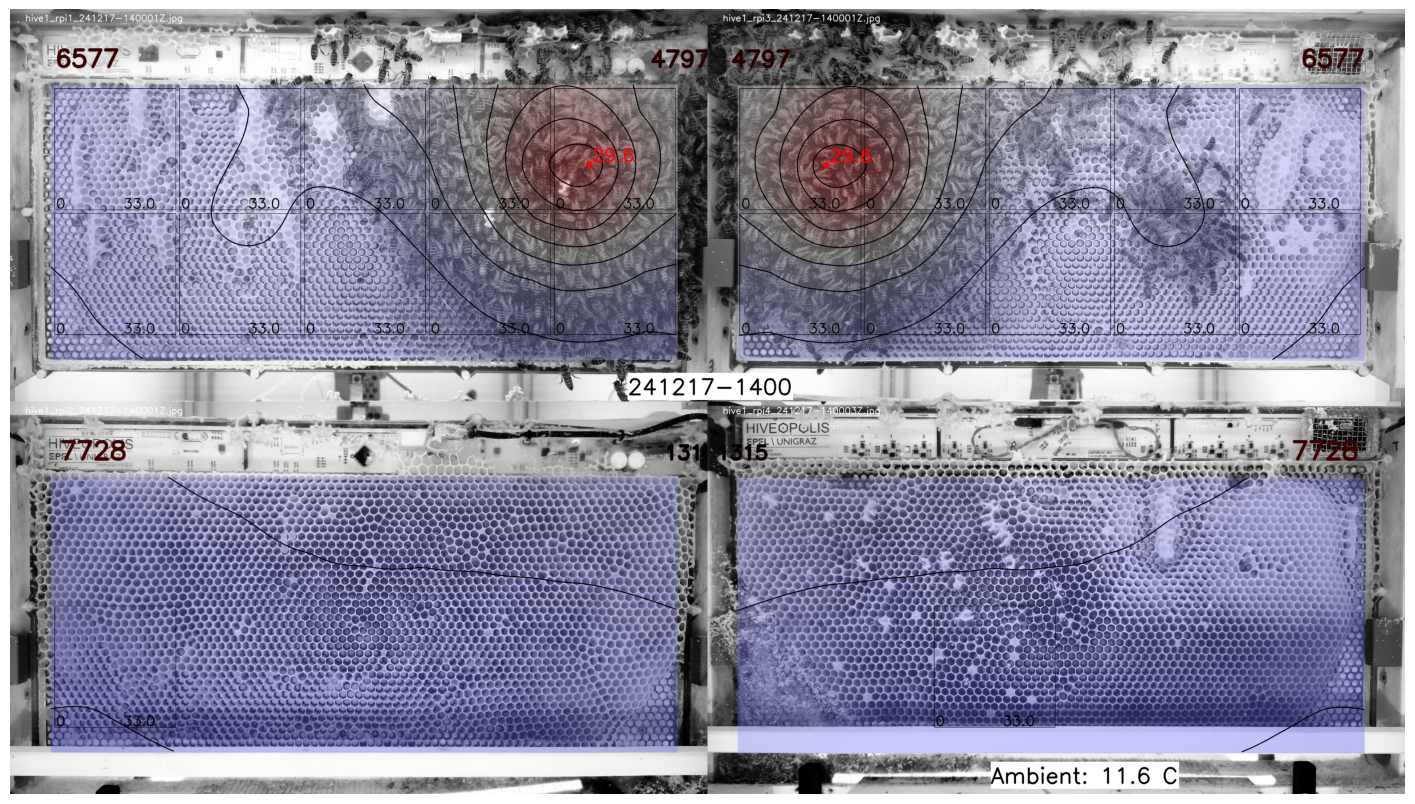

In [ ]:
vmax = max_temp
vmin = min_temp
# For a random time frame, generate the image of the hive and the thermal plot side by side with matplotlib
# This is just to check that everything is working fine
plt.figure(figsize=(18, 12))
frame = 300 # Frame within datetimes
dt = datetimes[frame]
_imgs_paths = imgs_paths_filtered.loc[dt].to_numpy()
imgs_names = [str(_imgs_paths[i]).split("/")[-1] for i in range(len(_imgs_paths))]
# Read the images using cv2
current_imgs = [cv2.imread(_imgs_paths[i], cv2.IMREAD_GRAYSCALE) if _imgs_paths[i] is not None else np.zeros((2592,4608), np.uint8) for i in range(len(_imgs_paths))]

hs_1 = Hive(current_imgs,imgs_names,ThermalFrame(upper.loc[dt].to_numpy()),ThermalFrame(lower.loc[dt].to_numpy()),co2_data.loc[dt],upper_htr.loc[dt],lower_htr.loc[dt])
contours = list(range(6, 32, 2))
snapshot = hs_1.snapshot(v_max=vmax,v_min=vmin,contours=contours,thermal_transparency=0.35)
plt.imshow(snapshot,cmap='gray')
plt.axis('off') 
plt.show()

#### Automation

Generating frames...


 21%|██        | 80/385 [16:25<1:02:36, 12.32s/it] 


KeyboardInterrupt: 

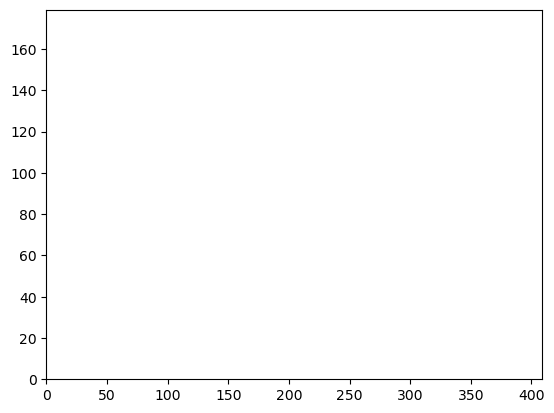

In [ ]:
final_imgs = []
print("Generating frames...")
for dt in tqdm(datetimes):
    _imgs_paths = imgs_paths_filtered.loc[dt].to_numpy()
    imgs_names = [str(_imgs_paths[j]).split("/")[-1] for j in range(len(_imgs_paths))]
    # Read the images using cv2
    current_imgs = []
    for _img_path in _imgs_paths:
        if _img_path is not None:
            img = cv2.imread(_img_path, cv2.IMREAD_GRAYSCALE)
            current_imgs.append(img)
        else:
            current_imgs.append(np.zeros((2592,4608), np.uint8))
            
    hs = Hive(current_imgs, imgs_names, ThermalFrame(upper.loc[dt].to_numpy()), ThermalFrame(lower.loc[dt].to_numpy()), co2_data.loc[dt], upper_htr.loc[dt], lower_htr.loc[dt])
    snapshot = hs.snapshot(v_max=max_temp, v_min=min_temp,contours=contours,thermal_transparency=0.4)

    final_imgs.append(snapshot)

# Change frames from rgb to bgr
print("Convert frames to bgr...")
for i in tqdm(range(len(final_imgs))):
    final_imgs[i] = cv2.cvtColor(final_imgs[i], cv2.COLOR_RGB2BGR)

dest = "outputVideos/"
# Make this a global path
print("Saving video...")
generateVideoFromList(final_imgs, dest="outputVideos/", name="hive" + hive + "_" + first_dt + "_" + last_dt, fps=10, grayscale=False)

# Cleanup step to release resources
multiprocessing.active_children()